100%|██████████| 40455/40455 [00:00<00:00, 42628.05it/s]


Finished building the Datasets.
somthing something
dalmation salvation
bicycler bicycle
outstreached outstretched
inground ground
plushie plush
floaties floating
using pretrained embedding weights


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


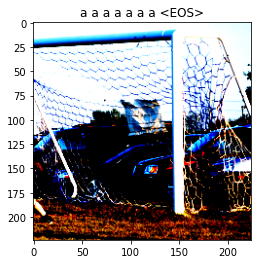

Epoch: 1 loss: 5.96930, perplexity: 954.38527


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


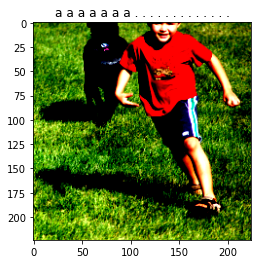

Epoch: 1 loss: 5.19749, perplexity: 253.39099


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


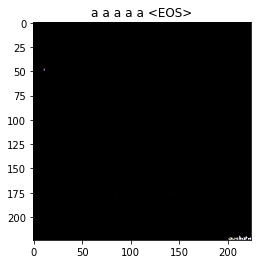

Epoch: 1 loss: 5.02336, perplexity: 160.90459


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


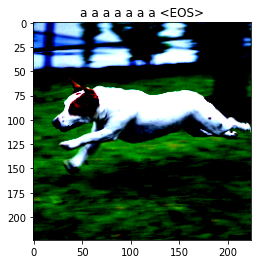

Epoch: 1 loss: 5.14603, perplexity: 148.30358


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


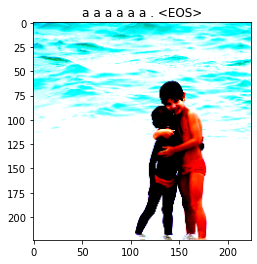

Epoch: 1 loss: 5.02493, perplexity: 139.83019


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


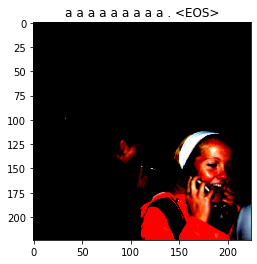

Epoch: 1 loss: 4.76859, perplexity: 130.87613


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


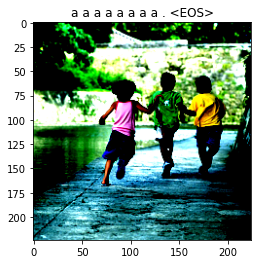

Epoch: 1 loss: 4.82642, perplexity: 132.24879


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


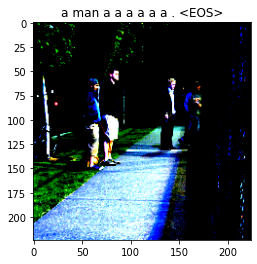

Epoch: 1 loss: 4.80321, perplexity: 129.85433


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


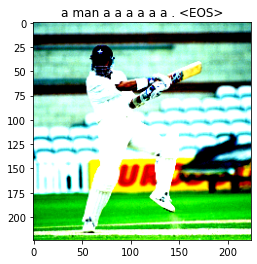

Epoch: 1 loss: 4.84120, perplexity: 122.39346


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


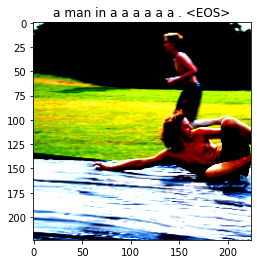

Epoch: 1 loss: 4.78557, perplexity: 115.93373


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


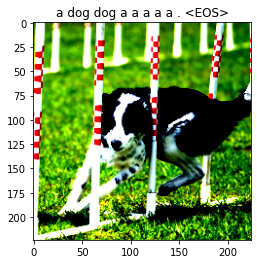

Epoch: 1 loss: 4.81704, perplexity: 123.23046


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


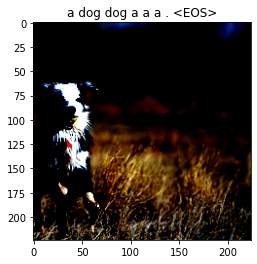

Epoch: 1 loss: 4.64644, perplexity: 107.72883


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


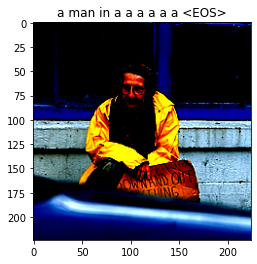

Epoch: 1 loss: 4.84567, perplexity: 112.25850


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


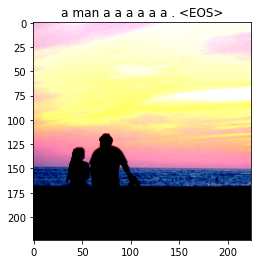

Epoch: 1 loss: 4.76198, perplexity: 109.53008


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


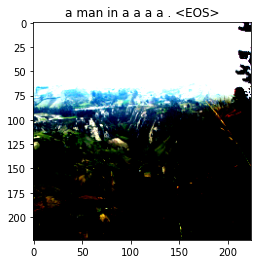

Epoch: 1 loss: 4.49278, perplexity: 99.18141


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


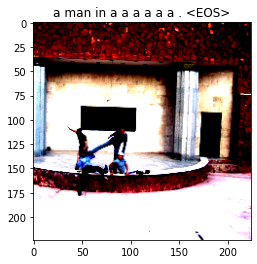

Epoch: 1 loss: 4.74845, perplexity: 96.47477


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


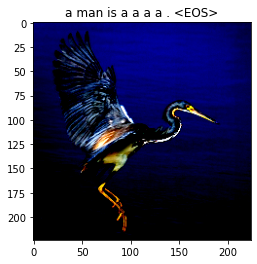

Epoch: 1 loss: 4.60217, perplexity: 94.43468


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


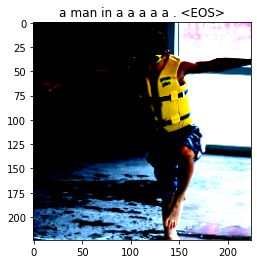

Epoch: 1 loss: 4.47575, perplexity: 91.51768


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


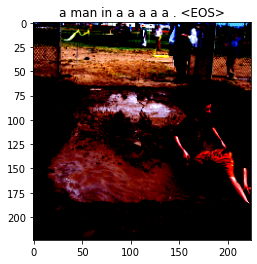

Epoch: 1 loss: 4.56912, perplexity: 90.95540


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


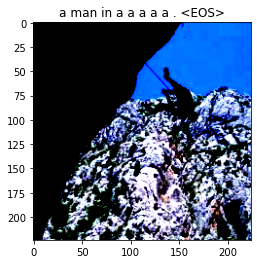

Epoch: 1 loss: 4.21244, perplexity: 84.71528


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


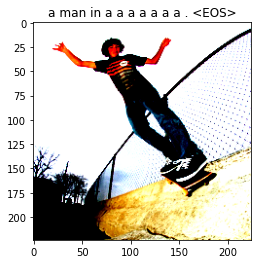

Epoch: 1 loss: 4.34040, perplexity: 81.70111


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


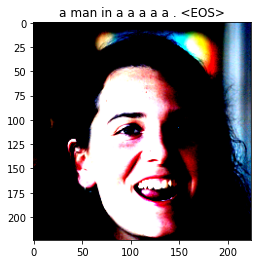

Epoch: 1 loss: 4.29975, perplexity: 82.79564


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


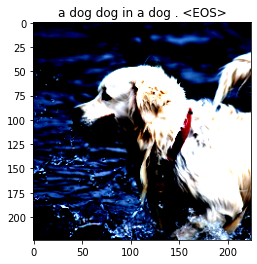

Epoch: 1 loss: 4.37458, perplexity: 74.80526


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


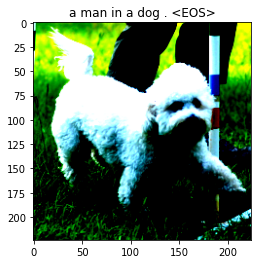

Epoch: 1 loss: 4.22325, perplexity: 71.35149


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


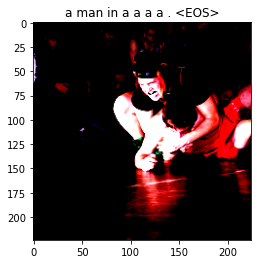

Epoch: 1 loss: 4.33463, perplexity: 77.00701


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


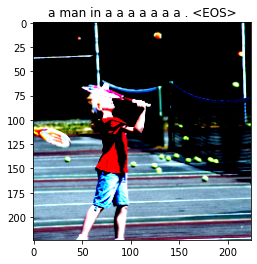

Epoch: 1 loss: 4.37323, perplexity: 72.74950


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


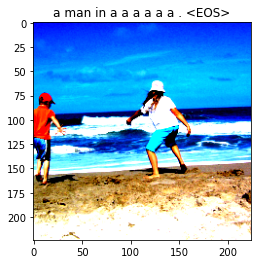

Epoch: 1 loss: 4.08961, perplexity: 69.41149


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


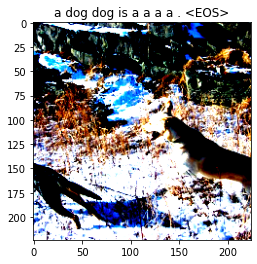

Epoch: 1 loss: 4.20304, perplexity: 68.36977


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


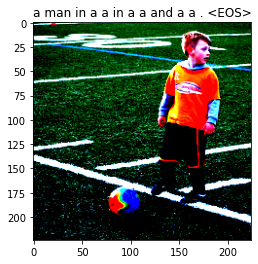

Epoch: 1 loss: 4.16909, perplexity: 66.49023


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


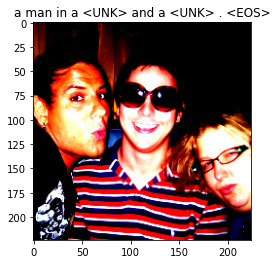

Epoch: 1 loss: 4.36793, perplexity: 67.20038


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


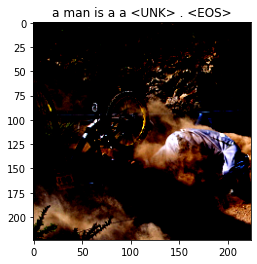

Epoch: 1 loss: 4.24101, perplexity: 63.81691


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


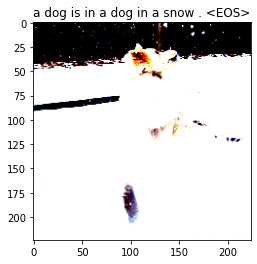

Epoch: 1 loss: 4.09108, perplexity: 67.88968


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


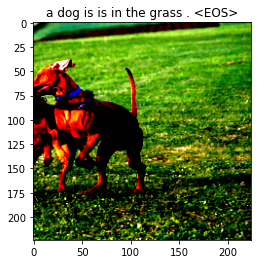

Epoch: 1 loss: 3.96958, perplexity: 56.59006


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


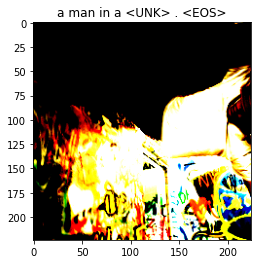

Epoch: 1 loss: 4.01092, perplexity: 61.23385


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


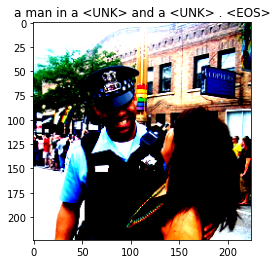

Epoch: 1 loss: 4.39617, perplexity: 61.62418


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


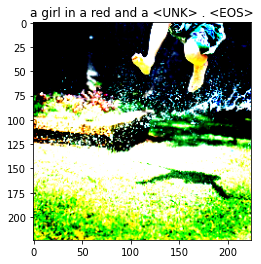

Epoch: 1 loss: 4.00191, perplexity: 54.62514


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


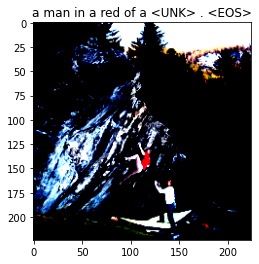

Epoch: 1 loss: 3.83552, perplexity: 54.46685


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


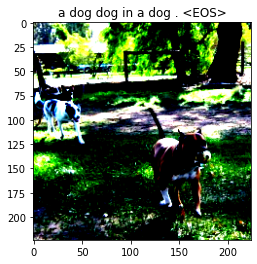

Epoch: 1 loss: 4.04295, perplexity: 54.59808


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


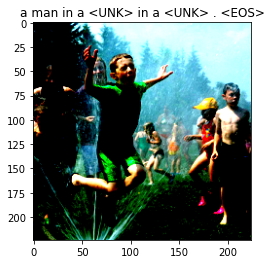

Epoch: 1 loss: 3.75942, perplexity: 54.38086


KeyboardInterrupt: 

In [31]:
from Train import *

In [1]:
from data import *

In [2]:
from models import *

In [3]:
vocab = build_vocab(captions_file_path='captions.txt')

100%|██████████| 40455/40455 [00:01<00:00, 40389.40it/s]


In [4]:
import torchvision.transforms as T


data_location = "."
BATCH_SIZE = 32
NUM_WORKER = 4

# defining the transform to be applied
transforms = T.Compose([
    T.Resize(226),
    T.RandomCrop(224),
    T.ToTensor(),
    T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

In [5]:
data_location = "."
BATCH_SIZE = 32
NUM_WORKER = 4

In [6]:
train,val,test = karpathy_split('captions.txt',karpathy_json_path='Karpathy_data.json')

In [7]:
train_dataset = FlickrDataset(root_dir='./Images',vocab= vocab, captions_df=train,transform=transforms)
val_dataset = FlickrDataset(root_dir='./Images',vocab= vocab, captions_df=val,transform=transforms)
test_dataset = FlickrDataset(root_dir='./Images',vocab= vocab, captions_df=test,transform=transforms)

In [12]:
from torchtext.vocab import GloVe
from textblob import TextBlob
g = GloVe(name ='6B', dim=100) 

In [9]:
from nltk.translate.bleu_score import corpus_bleu as bleu

In [10]:
bleu?

In [13]:
weights_matrix = load_embedding_weights(vocab, g)

somthing something
dalmation salvation
bicycler bicycle
outstreached outstretched
inground ground
plushie plush
floaties floating


In [14]:
len(vocab)

2994

In [15]:
# Hyperparams
embed_size = weights_matrix.size(1)
vocab_size = len(vocab)
attention_dim = 256
encoder_dim = 2048
decoder_dim = 512
learning_rate = 3e-4

In [16]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [17]:
model = EncoderDecoder(
    embed_size=embed_size,
    vocab_size=vocab_size,
    attention_dim=attention_dim,
    encoder_dim=encoder_dim,
    decoder_dim=decoder_dim,
    embedding_weights = weights_matrix
    
).to(device)

using pretrained embedding weights


In [18]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss(ignore_index=vocab.stoi["<PAD>"])
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [19]:
from torch.utils.data import DataLoader

In [20]:
um_epochs = 1
print_every = 1

pad_idx = vocab.stoi["<PAD>"]

data_loader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    num_workers=0,
    shuffle=True,
    collate_fn=CapsCollate(pad_idx=pad_idx, batch_first=True)
)

In [ ]:
for idx, (image, captions) in enumerate(iter(data_loader)):
    

In [21]:
dataiter = iter(data_loader)
img, true_caption = next(dataiter)

In [26]:
def f(x):
    return vocab.itos[x]

In [27]:
true_caption.apply_(f)

TypeError: an integer is required (got type str)

In [30]:
def train_one_epoch(data_loader, model, criterion, epoch, loss_list):
    model.train()
    for idx, (image, captions) in enumerate(iter(data_loader)):
    
        image, captions = image.to(device), captions.to(device)

        # Zero the gradients.
        optimizer.zero_grad()

        # Feed forward
        outputs, attentions = model(image, captions)

        # Calculate the batch loss.
        targets = captions[:, 1:]
        loss = criterion(outputs.view(-1, vocab_size), targets.reshape(-1))

        # Backward pass.
        loss.backward()

        # Update the parameters in the optimizer.
        optimizer.step()

        #total_loss += loss.item()

        loss_list.append(loss.item())


In [32]:
loss_list = []

train_one_epoch(data_loader, model, criterion, 1, loss_list)

KeyboardInterrupt: 

In [ ]:
def validate(val_loader, model, criterion):
    """
    Performs one epoch's validation.
    :param val_loader: DataLoader for validation data.
    :param encoder: encoder model
    :param decoder: decoder model
    :param criterion: loss layer
    :return: BLEU-4 score
    """
    model.eval()  # eval mode (no dropout or batchnorm)

    references = list()  # references (true captions) for calculating BLEU-4 score
    hypotheses = list()  # hypotheses (predictions)

    # explicitly disable gradient calculation to avoid CUDA memory error
    # solves the issue #57
    with torch.no_grad():
        # Batches
        for i, (imgs, caps, caplens, allcaps) in enumerate(val_loader):

            # Move to device, if available
            imgs = imgs.to(device)
            caps = caps.to(device)
            caplens = caplens.to(device)

            # Forward prop.
            if encoder is not None:
                imgs = encoder(imgs)
            scores, caps_sorted, decode_lengths, alphas, sort_ind = decoder(imgs, caps, caplens)

            # Since we decoded starting with <start>, the targets are all words after <start>, up to <end>
            targets = caps_sorted[:, 1:]

            # Remove timesteps that we didn't decode at, or are pads
            # pack_padded_sequence is an easy trick to do this
            scores_copy = scores.clone()
            scores, _ = pack_padded_sequence(scores, decode_lengths, batch_first=True)
            targets, _ = pack_padded_sequence(targets, decode_lengths, batch_first=True)

            # Calculate loss
            loss = criterion(scores, targets)

            # Add doubly stochastic attention regularization
            loss += alpha_c * ((1. - alphas.sum(dim=1)) ** 2).mean()

            # Keep track of metrics
            losses.update(loss.item(), sum(decode_lengths))
            top5 = accuracy(scores, targets, 5)
            top5accs.update(top5, sum(decode_lengths))
            batch_time.update(time.time() - start)

            start = time.time()

            if i % print_freq == 0:
                print('Validation: [{0}/{1}]\t'
                      'Batch Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                      'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                      'Top-5 Accuracy {top5.val:.3f} ({top5.avg:.3f})\t'.format(i, len(val_loader), batch_time=batch_time,
                                                                                loss=losses, top5=top5accs))

            # Store references (true captions), and hypothesis (prediction) for each image
            # If for n images, we have n hypotheses, and references a, b, c... for each image, we need -
            # references = [[ref1a, ref1b, ref1c], [ref2a, ref2b], ...], hypotheses = [hyp1, hyp2, ...]

            # References
            allcaps = allcaps[sort_ind]  # because images were sorted in the decoder
            for j in range(allcaps.shape[0]):
                img_caps = allcaps[j].tolist()
                img_captions = list(
                    map(lambda c: [w for w in c if w not in {word_map['<start>'], word_map['<pad>']}],
                        img_caps))  # remove <start> and pads
                references.append(img_captions)

            # Hypotheses
            _, preds = torch.max(scores_copy, dim=2)
            preds = preds.tolist()
            temp_preds = list()
            for j, p in enumerate(preds):
                temp_preds.append(preds[j][:decode_lengths[j]])  # remove pads
            preds = temp_preds
            hypotheses.extend(preds)

            assert len(references) == len(hypotheses)

        # Calculate BLEU-4 scores
        bleu4 = corpus_bleu(references, hypotheses)

        print(
            '\n * LOSS - {loss.avg:.3f}, TOP-5 ACCURACY - {top5.avg:.3f}, BLEU-4 - {bleu}\n'.format(
                loss=losses,
                top5=top5accs,
                bleu=bleu4))

    return bleu4

In [30]:
loss_list = []
perplexity_list = []
total_loss = 0
for epoch in range(1, 1 + 1):
    for idx, (image, captions) in enumerate(iter(data_loader)):
        image, captions = image.to(device), captions.to(device)

        # Zero the gradients.
        optimizer.zero_grad()

        # Feed forward
        outputs, attentions = model(image, captions)

        # Calculate the batch loss.
        targets = captions[:, 1:]
        loss = criterion(outputs.view(-1, vocab_size), targets.reshape(-1))

        # Backward pass.
        loss.backward()

        # Update the parameters in the optimizer.
        optimizer.step()

        total_loss += loss.item()

        loss_list.append(loss.item())
        if (idx + 1) % 10 == 0:
            perplexity = total_loss / print_every
            perplexity = np.exp(perplexity)
            perplexity_list.append(perplexity)
            # generate the caption
            model.eval()
            with torch.no_grad():
                dataiter = iter(data_loader)
                img, true_caption = next(dataiter)
                true_caption = true_caption[0:1]
                features = model.encoder(img[0:1].to(device))
                caps, alphas = model.decoder.generate_caption(features, vocab=vocab)
                caption = ' '.join(caps)
                show_image(img[0], title=caption)
            print("Epoch: {} loss: {:.5f}, perplexity: {:.5f}".format(epoch, loss.item(), perplexity))
            total_loss = 0
            model.train()



plt.plot(loss_list)
plt.title('Loss')
plt.show()

plt.plot(perplexity_list)
plt.title('Perplexity')
plt.show()

KeyboardInterrupt: 

In [215]:
!ls ./Flicker8k_Dataset

1000268201_693b08cb0e.jpg 2701487024_e866eb4550.jpg 3391209042_d2de8a8978.jpg
1001773457_577c3a7d70.jpg 2701603045_6cbdc4ce7c.jpg 3391924827_53b31542ce.jpg
1002674143_1b742ab4b8.jpg 2701895972_8605c4e038.jpg 3392019836_c7aeebca1c.jpg
1003163366_44323f5815.jpg 2702506716_17a7fb3ba4.jpg 3392293702_ccb0599857.jpg
1007129816_e794419615.jpg 270263570_3160f360d3.jpg  3392851587_a638ff25e2.jpg
1007320043_627395c3d8.jpg 2703155733_19ac6f97a8.jpg 3393035454_2d2370ffd4.jpg
1009434119_febe49276a.jpg 2704257993_d485058a5f.jpg 3393152604_27bd1037f2.jpg
1012212859_01547e3f17.jpg 2704362232_7d84503433.jpg 3393343330_b13df4d8ec.jpg
1015118661_980735411b.jpg 2704379125_9c35650d16.jpg 3393394134_0caac47e1c.jpg
1015584366_dfcec3c85a.jpg 2704934519_457dc38986.jpg 3393446245_37dd3f3b59.jpg
101654506_8eb26cfb60.jpg  2705793985_007cc703fb.jpg 339350939_6643bfb270.jpg
101669240_b2d3e7f17b.jpg  2705947033_5999147842.jpg 3393926562_66cc01b001.jpg
1016887272_03199f49c4.jpg 2706023395_ac9eba0e42.jpg 3394070357_cb